# Section 2  
Name: Michelle Fong  


## I

In [6]:
def plot_scatter_by_label(X, y, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        fig.set_figheight(6)
        fig.set_figwidth(8)
    # Map labels to "0" and "1"
    categories = np.unique(y)
    for cat in categories:
        ax.scatter(X[y==cat, 0], X[y==cat, 1], label='{0}'.format(cat), alpha=0.25)
        ax.scatter(np.mean(X[y==cat, 0]), np.mean(X[y==cat, 1]), c='k', marker='x', s=200)
    ax.set_xlabel('X0', size=15)
    ax.set_ylabel('X1', size=15)
    ax.set_title(title if title else "Gaussian Mixture", size=20)
    ax.grid()
    plt.legend()
    return ax


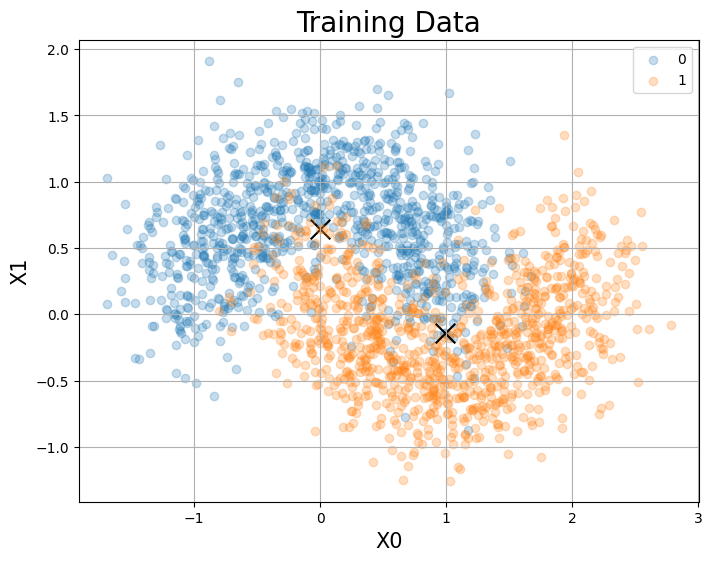

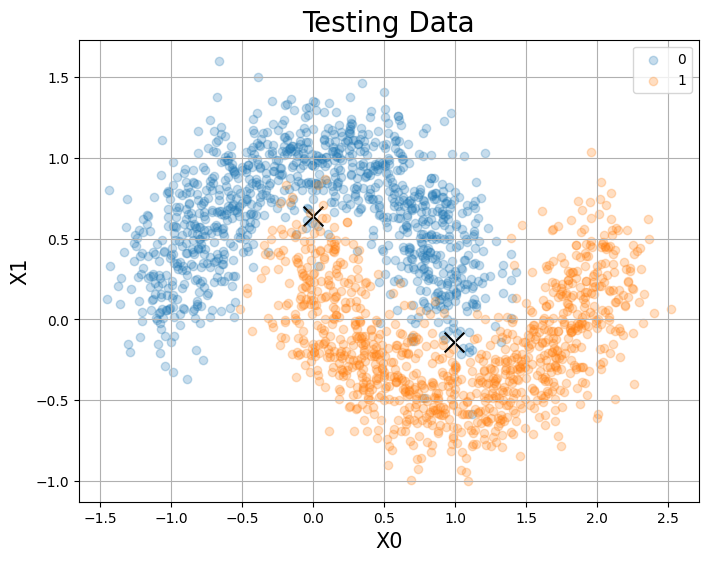

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

train_data = pd.read_csv('Task2B_train.csv')
test_data = pd.read_csv('Task2B_test.csv')
# Extract features and labels
x_train = train_data.drop(columns=['label']).values
y_train = train_data['label'].values
x_test = test_data.drop(columns=['label']).values
y_test = test_data['label'].values

# Plot training data
plot_scatter_by_label(x_train, y_train, title="Training Data")

# Plot testing data
plot_scatter_by_label(x_test, y_test, title="Testing Data")

plt.show()

## II

In [11]:
class Perceptron:
    
    def __init__(self, eta=0.01, tau_max=10000, epsilon=0.005, random_state=None):
        self.eta = eta   # learning rate
        self.tau_max = tau_max   # max number of iterations
        self.epsilon = epsilon   # tolerable error
        self.random_state = random_state

    def fit(self, x, y):
        RNG = np.random.default_rng(self.random_state)
        # number of samples and features
        n, p = x.shape

        # weight vectors at different iterations during training.
        self.w_trace_ = np.empty((self.tau_max, p))     
        # indices of the training points considered in each iteration.
        self.xy_idx_trace_ = np.empty(self.tau_max, int)
        
        # initialisation of iteration counter and weights
        tau = 0 
        self.w_ = self.w_trace_[0,:] = RNG.normal(size=p) 
        terminate = False
        
        while not (terminate or (self.predict(x)!=y).mean()<self.epsilon):
            # random order to consider training data
            order = RNG.choice(np.arange(n),size = n ,replace = False)
            for i in range(n):
                if self.predict(x[order][i]) != y[order][i]:
                    self.w_ = self.w_ + (2*y[order][i]-1)*self.eta * x[order][i]
                
                self.w_trace_[tau+1] = self.w_
                self.xy_idx_trace_[tau] = order[i]

                tau +=1
                if tau == self.tau_max-1:
                    terminate = True
                    break
        
        # remove empty rows from traces
        self.w_trace_ = self.w_trace_[:tau] 
        self.xy_idx_trace_ = self.xy_idx_trace_[:tau-1]

        return self

    def predict(self, x):
        return (x.dot(self.w_) >= 0).astype(int)


In [12]:
perceptron_a = Perceptron(eta=0.1,random_state=0)
perceptron_a.fit(X_train, y_train)

from sklearn.metrics import zero_one_loss

train_error = zero_one_loss(perceptron_a.predict(x_train), y_train)
test_error = zero_one_loss(perceptron_a.predict(x_test), y_test)

train_error, test_error

(0.1945, 0.16649999999999998)

In [13]:
perceptron_b = Perceptron(eta=1,random_state=0)
perceptron_b.fit(X_train, y_train)

from sklearn.metrics import zero_one_loss

train_error = zero_one_loss(perceptron_b.predict(x_train), y_train)
test_error = zero_one_loss(perceptron_b.predict(x_test), y_test)

train_error, test_error

(0.21150000000000002, 0.1835)

In [14]:
perceptron_a.w_

array([ 0.00565291, -0.09361628])

<Figure size 500x500 with 0 Axes>

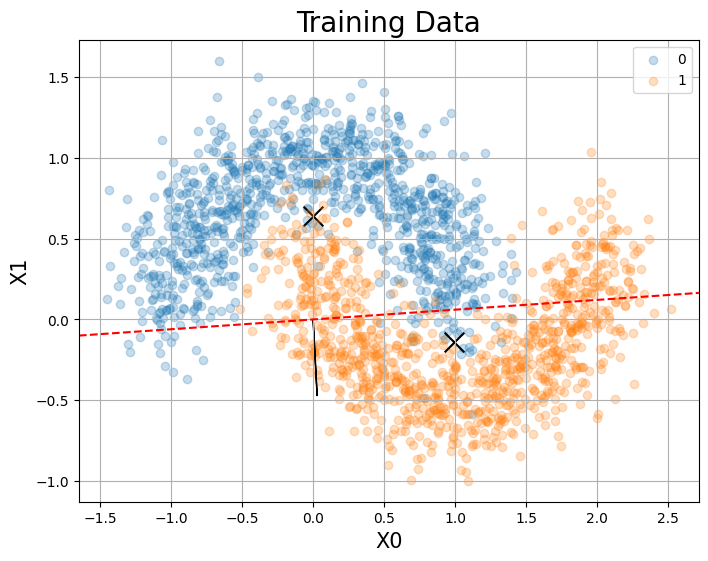

In [15]:
def plot_line(slope, intercept, ax=None, shape='--', **kwargs):
    ax = plt.gca() if ax is None else ax
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.set_ylim(ax.get_ylim())
    ax.set_xlim(ax.get_xlim())
    ax.plot(x_vals, y_vals, shape, **kwargs)

def plot_decision_boundary_from_weights(weights, ax=None):
    slope = -weights[0]/weights[1]
    intercept = 0
    plot_line(slope, intercept, ax, shape='--', color='red')

plt.figure(figsize=(5, 5))
plot_scatter_by_label(x_test, y_test, title="Training Data")
plt.arrow(0, 0, *(perceptron_a.w_*5))
plot_decision_boundary_from_weights(perceptron_a.w_)
plt.show()

## III

In [16]:
N = x_train.shape[0]
D = x_train.shape[1]

T1 = y_train.reshape(-1, 1)
T2 = y_test.reshape(-1, 1)

N, D

(2000, 2)

In [17]:
# auxiliary functions 
## the activation function (sigmoid here)
def h(z):
    return (1/(1+np.exp(-3*z)))

## the derivitive of the activation function (sigmoid here)
def h_d(z):
    return (h(z)*(1-h(z)))

## Accuracy
def accuracy(pred, label):
    return (pred == label).mean()


def feedforward(Xi, Ti, W1, b1, W2, b2):
    ### 1st (input) layer 
    a1 = Xi                           
    y = Ti                          
    ### 2nd (hidden) layer
    z2 = a1 @ W1 + b1                            
    a2 = h(z2)                                  
    ### 3rd (output) layer
    z3 = a2 @ W2 + b2                         
    a3 = h(z3)                            
    return(a1, a2, a3, y, z2, z3)

def backpropagation(Ti, W2, z2, z3, a3):
    ### 3rd (output) layer
    d3 = -(Ti-a3) * h_d(z3)                          
    ### 2nd (hidden) layer
    d2 =  (d3 @ W2.T) * h_d(z2)                          
    return(d2,d3)


# one more aux functions before we start
def prediction(X, W1, W2, b1, b2, threshold=0.5):
    # we use the feedforward network we defined to obtain output activation (a3), we don't care about the
    # rest so we use _ to store them. We also don't need to send T so we just send 1 instead
    _,_, a3,_,_,_ = feedforward(X, 1,W1,b1, W2, b2)
    return np.array([1 if above_thresh else 0 for above_thresh in (a3 >= threshold)]).reshape(-1,1)
    

def NN(K, X1, T1, X2, T2,eta, epoch_max=2500, seed=None):
    if seed is not None: np.random.seed(seed)
    # Setting parameters
    alpha = 0.0001 # regularization term
    N,D = X1.shape

    # initialization
    epoch = 1 # epoch (iteration) counter
    terminate = False   # termination criteria

    ## weight vectors/matrices initialization
    ### w stands for weight and b for bias
    ### the numbers after the letters indicates the layer number
    W1 = np.random.normal(scale=0.5, size=(D,K)) * eta
    b1 = np.zeros((1,K))
    W2 = np.random.normal(scale=0.5, size=(K,1)) * eta
    b2 = np.zeros((1,1))
    ## tracing accuracy of the model 
    train_accuracy = []
    test_accuracy = []
    
    # main loop
    while (not terminate):
        # note that this is the vectorised implementaion so it slightly differs from the above implementation
        # try to spot and rationalize the differences.
        ## Feedforward:
        a1, a2, a3, y, z2, z3 = feedforward(X1, T1, W1, b1, W2, b2)

        ## Backpropagation:
        d2, d3 = backpropagation(T1, W2, z2, z3, a3)

        ## calculate the delta values
        ### 1st layer
        W1_d = a1.T @ d2
        b1_d = d2
        ### 2nd layer
        W2_d = a2.T @ d3
        b2_d = d3

        ## update weight vectors and matrices
        ### 1st (input) layer
        W1 = W1 - eta * (W1_d/N + alpha*W1)
        b1 = b1 - eta * (b1_d.mean(axis=0, keepdims=True))
        ### 2nd (hidden) layer
        W2 = W2 - eta * (W2_d/N + alpha*W2)
        b2 = b2 - eta * (b2_d.mean(axis=0, keepdims=True))

        ## trace train  and test accuracy
        train_accuracy.append(accuracy(prediction(X1, W1, W2, b1, b2), T1))
        test_accuracy.append(accuracy(prediction(X2, W1, W2, b1, b2), T2))
        ## increase the iteration counter
        epoch = epoch + 1

        ## check the termination criteria
        if (epoch >= epoch_max): terminate = True
        
    return train_accuracy,test_accuracy,W1, W2, b1, b2,a3,z3


In [18]:
K_values = range(5, 41, 5)
eta_values = [0.01, 0.001]
testing_errors = {}

Model: K=5, eta=0.01
Model: K=5, eta=0.001
Model: K=10, eta=0.01
Model: K=10, eta=0.001
Model: K=15, eta=0.01
Model: K=15, eta=0.001
Model: K=20, eta=0.01
Model: K=20, eta=0.001
Model: K=25, eta=0.01
Model: K=25, eta=0.001
Model: K=30, eta=0.01
Model: K=30, eta=0.001
Model: K=35, eta=0.01
Model: K=35, eta=0.001
Model: K=40, eta=0.01
Model: K=40, eta=0.001
Best combination: K=5, eta=0.01, Testing Error=0.1870


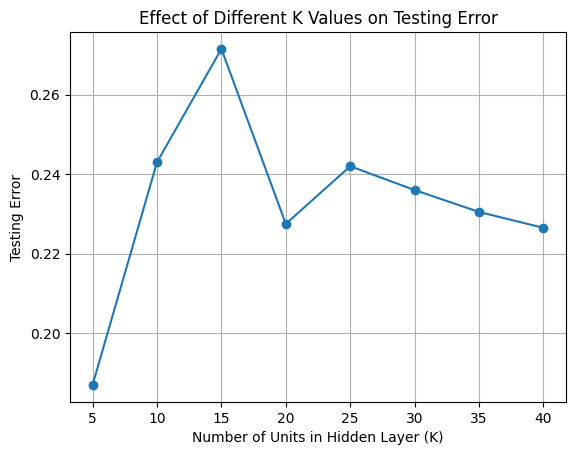

In [19]:
for K in K_values:
    for eta in eta_values:
        print(f'Model: K={K}, eta={eta}')
        
        train_accuracy, test_accuracy, best_W1, best_W2, best_b1, best_b2,_,_  = NN(K, x_train, T1, x_test, T2, eta=eta, seed=1)
        
        # convert accuracy to testing error
        testing_error = 1.0 - accuracy(prediction(x_test, best_W1, best_W2, best_b1, best_b2), T2)
        
        # storing testing error for K and eta
        testing_errors[(K, eta)] = testing_error

# min to find best k and eta
best_K, best_eta = min(testing_errors, key=testing_errors.get)
# extract corresponding testing error
best_testing_error = testing_errors[(best_K, best_eta)]
print(f'Best combination: K={best_K}, eta={best_eta}, Testing Error={best_testing_error:.4f}')

# Plot the effect of different K values on testing error
testing_errors_list = [testing_errors[(K, best_eta)] for K in K_values]

plt.plot(K_values, testing_errors_list, marker='o')
plt.xlabel('Number of Units in Hidden Layer (K)')
plt.ylabel('Testing Error')
plt.title('Effect of Different K Values on Testing Error')
plt.grid()
plt.show()


Model: K=5, eta=0.01
Model: K=5, eta=0.001
Model: K=10, eta=0.01
Model: K=10, eta=0.001
Model: K=15, eta=0.01
Model: K=15, eta=0.001
Model: K=20, eta=0.01
Model: K=20, eta=0.001
Model: K=25, eta=0.01
Model: K=25, eta=0.001
Model: K=30, eta=0.01
Model: K=30, eta=0.001
Model: K=35, eta=0.01
Model: K=35, eta=0.001
Model: K=40, eta=0.01
Model: K=40, eta=0.001
Best combination: K=5, eta=0.01, Testing Error=0.2005


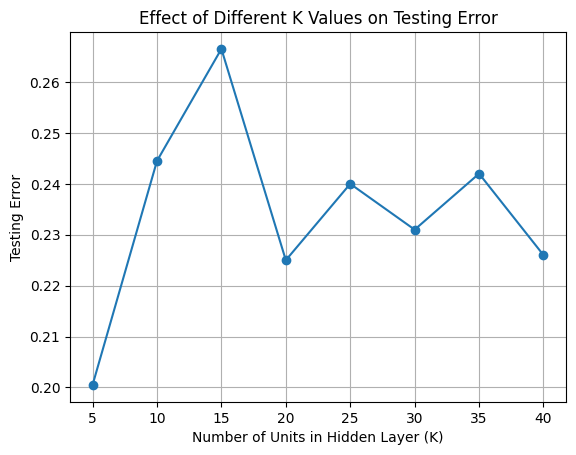

In [23]:
training_errors = {}
for K in K_values:
    for eta in eta_values:
        print(f'Model: K={K}, eta={eta}')
        
        train_accuracy, test_accuracy, best_W1, best_W2, best_b1, best_b2,_,_  = NN(K, x_train, T1, x_test, T2, eta=eta, seed=1)
        
        # convert accuracy to testing error
        train_error = 1.0 - accuracy(prediction(x_train, best_W1, best_W2, best_b1, best_b2), T1)
        
        # storing testing error for K and eta
        training_errors[(K, eta)] = train_error

# min to find best k and eta
best_K, best_eta = min(training_errors, key=training_errors.get)
# extract corresponding testing error
best_train_error = training_errors[(best_K, best_eta)]
print(f'Best combination: K={best_K}, eta={best_eta}, Training Error={best_train_error:.4f}')

# Plot the effect of different K values on testing error
train_error_list = [training_errors[(K, best_eta)] for K in K_values]

plt.plot(K_values, train_error_list, marker='o')
plt.xlabel('Number of Units in Hidden Layer (K)')
plt.ylabel('Testing Error')
plt.title('Effect of Different K Values on Training Error')
plt.grid()
plt.show()


Best combination: K=5, eta=0.01, Testing Error=0.1870


<Figure size 800x600 with 0 Axes>

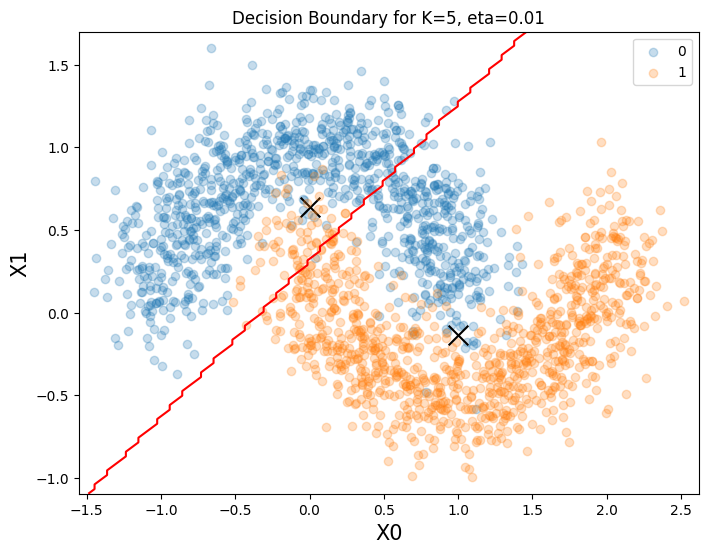

In [20]:
# Train the neural network with the best combination of parameters
print(f'Best combination: K={best_K}, eta={best_eta}, Testing Error={best_testing_error:.4f}')

_, _, best_W1, best_W2, best_b1, best_b2,a3,z3 = NN(best_K, x_train, T1, x_test, T2, eta=best_eta, seed=1)
 
# Generate a grid of points
x_min, x_max = x_test[:, 0].min() - 0.1, x_test[:, 0].max() + 0.1
y_min, y_max = x_test[:, 1].min() - 0.1, x_test[:, 1].max() + 0.1

# x and y coordinates
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), 
                     np.linspace(y_min, y_max, 100))

# flattern to conver grid of points into a list of coordinates.
grid_points = np.c_[xx.ravel(), yy.ravel()]

# prediction lables of 0/1
predictions = prediction(grid_points, best_W1, best_W2, best_b1, best_b2)

# reshape the predictions 
predictions = predictions.reshape(xx.shape)

# plot the scatter plot
plt.figure(figsize=(8, 6))
plot_scatter_by_label(x_test, y_test, title="Testing Data")

# # the decision boundary line
plt.contour(xx, yy, predictions, levels=[0.5], colors='red')

plt.xlabel('X0')
plt.ylabel('X1')
plt.title(f'Decision Boundary for K={best_K}, eta={best_eta}')
plt.legend()
plt.grid()
plt.show()


## IV

In perceptron model with eta = 0.1, the testing error is 0.1665.  
In 3 layer neural network, the best combination is: K=5, eta=0.01, Testing Error=0.1870  
Therefore it is concluded that perceptron model is performing better in this case. 

The dataset in linearly inseparable. Since perceptron model assumes linear sepabale data, it was expected that model would perform worse. Howerver, the testing error of the neural network is higher.

From the graph, the decision boundary of neural network is rather steep compared to that of perceptron model. Observing from the scatter plot of 2 clusters, the ideal boundary should be flatter. With the ideal boundary very close to linear line, neural network might lead to overfitting causing a higher testing error, especially when the neural network model assumes a 5 hidden unit and a sigmoid activation function that aims to capture non-linear pattern.  

Looking at the effect of different K values on testing error, it is found that the testing error increaesd after k=10 and 15, then decrease afterwards. This might show that the model overfit and become too complex. After k=15, the model become more complex and the additional hidden layer allow capturing more features and lower the testing error. The decision boundary of the neural network model is a squiggly line, showing it was affected by the noise which also support the model overfit to the training data.